
The goal is to simulate a simple time series that exhibits variability above the noise level, and describe the detailed shape of $p(\sigma)$. Finally I want to take few hundred real objects from S82 FP dataset, and calculate properties of p(\sigma) for that subsample, to ensure optimal performance. 

Each PDF is sampled by a grid of 70 points, with minimum set at $\sigma = 0$, and maximum at the maximum of the boostrapped resample of the histogram of $\sigma$ resulting from the approximate method. 

For each lightcurve we calculate $p(\sigma)$, for which we calculate: 
* the expectation value of $\sigma$ (i.e. mean):  $\langle \sigma \rangle= \frac{\sum \sigma p(\sigma_{int})}{\sum p(\sigma_{int})} $
* standard deviation of $\sigma$, $st.dev.(\sigma)$, found from the $\sqrt{(Variance)}=\left(\frac{\sum \sigma_{int}^{2}p(\sigma_{int}) } {\sum p(\sigma_{int})} - \langle \sigma_{int} \rangle^{2} \right) ^{1/2}$
* weighted median($\sigma$)  (the weighted 50-th percentile )
* the robust interquartile range assuming Gaussian origin: $\sigma_{G} = 0.741 * (percentile(75)  - percentile(25))$ using weighted percentiles 
* assuming $p(\sigma)$ normalized : the probability for $\sigma$ to lie between  $\langle \sigma \rangle \pm 2 \, st.dev(\sigma)$


In [16]:


import numpy as np
import matplotlib.pyplot as plt 
import sys
sys.path.insert(0, '/Users/chris/GradResearch/SDSS_S82_FP_research/packages/')
import variabilityFunctions as varF

import imp
imp.reload(varF)

<module 'variabilityFunctions' from '/Users/chris/GradResearch/SDSS_S82_FP_research/packages/variabilityFunctions.py'>

{'GaussLike': True, 'mean': 0.10520763368478686, 'probInTwoStdev': 0.9737910784599737, 'stdev': 0.031437216057510445, 'sigmaG': 0.024911730062502101, 'median': 0.092415024513531285}
{'GaussLike': True, 'mean': 0.17344871687477156, 'probInTwoStdev': 0.94505903209982933, 'stdev': 0.036291781353776233, 'sigmaG': 0.030445036775745792, 'median': 0.15401171982874229}
{'GaussLike': True, 'mean': 0.30057590065036477, 'probInTwoStdev': 0.95312913766438923, 'stdev': 0.052709470395867861, 'sigmaG': 0.050849331391778253, 'median': 0.28295358423187023}
{'GaussLike': True, 'mean': 0.38054944207833524, 'probInTwoStdev': 0.94376646969917877, 'stdev': 0.062346067801765687, 'sigmaG': 0.062953640903984906, 'median': 0.37153942932002437}
{'GaussLike': True, 'mean': 0.52530035357403237, 'probInTwoStdev': 0.96963199523156929, 'stdev': 0.065333679618261017, 'sigmaG': 0.052012189017298288, 'median': 0.50283828583655488}
{'GaussLike': True, 'mean': 0.6830558386805734, 'probInTwoStdev': 0.9489531467086183, 'std

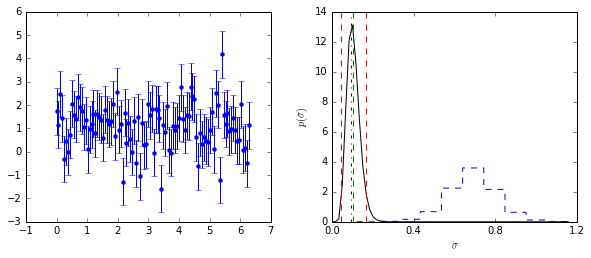

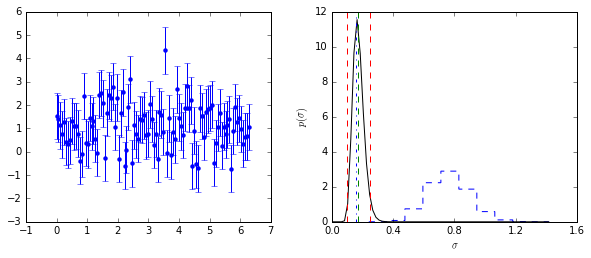

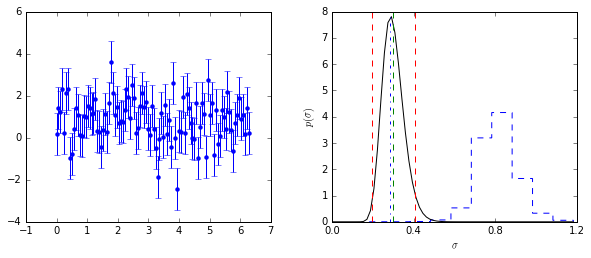

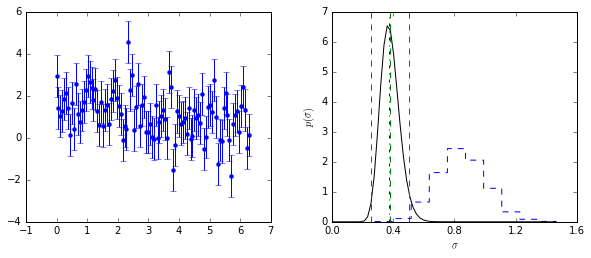

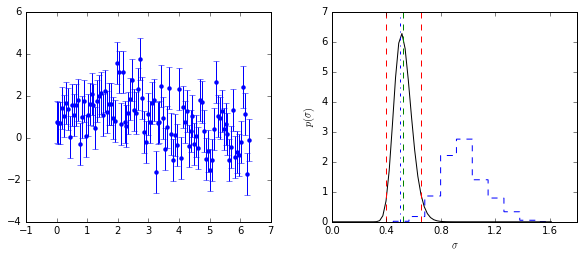

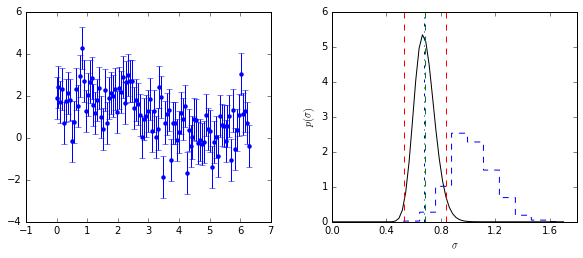

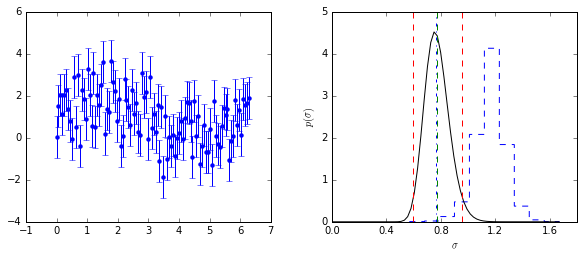

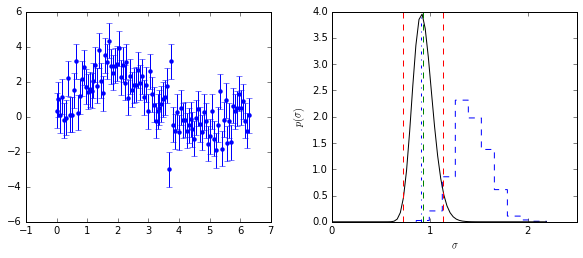

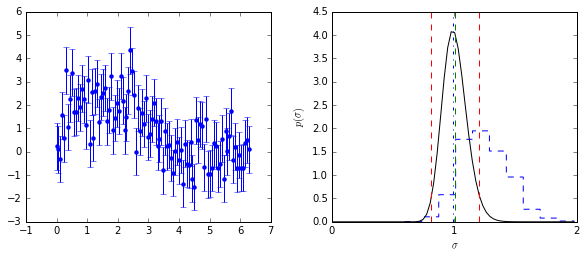

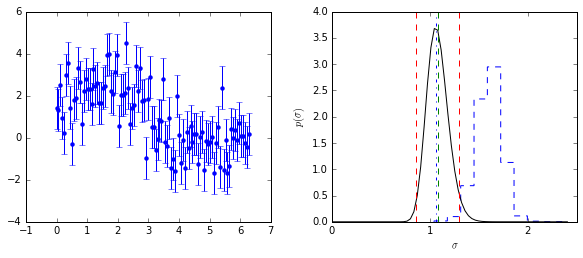

In [7]:
%matplotlib inline
# initialize the time series 
sigma_0 = 1.0 
A = 1.0 
N = 100 
Nboot = 10000

# calculate the integral between +/- 2 st.dev. in a true Gaussian 
from scipy.stats import norm
mean, var, skew, kurt = norm.stats(moments='mvsk')
p_Gaussian = norm.sf(mean-2*np.sqrt(var))-norm.sf(mean+2*np.sqrt(var))


t = np.linspace(0,2*np.pi, num=N)

for A in np.linspace(0.1,1.5,10):
    stats = {}

    ei = np.random.normal(loc=0.0, scale=sigma_0, size=len(t)) 
    xi = A* np.sin(t) + 1 + ei

    # plot the time series 
    fig,ax = plt.subplots(1,2, figsize=(9,4))
    label = 'xi=A sin(t)+1+'+r'$\mathcal{N}(0,\sigma)$'+ ', '+r'$\sigma=$'+str(sigma_0)
    ax[0].scatter(t,xi, lw=0, label=label)
    ax[0].errorbar(t,xi,sigma_0, ls='')

    plot_data, mu_max, sigma_max = varF.get_mu_sigma(xi,ei, N_boot=Nboot, return_plot_data=True)

    # Plot the sigma PDF 
    fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.15, top=0.88)

    mu, sigma = plot_data['mu'], plot_data['sigma']
    p_mu, p_sigma = plot_data['p_mu'], plot_data['p_sigma']

    # plot the marginalized distribution
    ax[1].plot(sigma, p_sigma, '-k', label='full')

    # plot the bootstrap distribution
    ax[1].hist(plot_data['sigma_boot'], histtype='step', linestyle='dashed',
        color='b', normed=True, label='approx')

    # plot the mean, median, mean +/- 2*stdev  levels 
    E = np.sum(p_sigma*sigma) / np.sum(p_sigma)   # mean 
    stdev = np.sqrt(np.sum(sigma*sigma*p_sigma)/ np.sum(p_sigma)  - E*E)  # stdev 
    median = varF.calcWeightedPercentile(sigma,p_sigma,50)

    # weighted interquartile sigmaG 
    q75 = varF.calcWeightedPercentile(sigma, p_sigma, 75)
    q25 = varF.calcWeightedPercentile(sigma, p_sigma, 25) 
    sigmaG_weighted  = 0.7413 * (q75-q25)

    # prob of being withing +/- w stdev 
    dsigma = sigma[1]-sigma[0]
    mask = (sigma < E+2*stdev) * (sigma > E-2*stdev)
    prob = np.sum(p_sigma[mask]*dsigma)

    # store data for this PDF 
    stats['mean'] = E
    stats['median'] = median 
    stats['stdev'] = stdev
    stats['sigmaG'] = sigmaG_weighted
    stats['probInTwoStdev'] = prob
    if prob >= 0.9*p_Gaussian:
        GaussLike = True
    else:
        GaussLike = False 
        
    stats['GaussLike'] = GaussLike

    ax[1].axvline(E, color='green', ls='--')
    ax[1].axvline(E+2*stdev, color='red', ls='--')
    ax[1].axvline(E-2*stdev, color='red', ls='--')
    ax[1].axvline(median, color='blue', ls='-.')

    # set the right labels 
    ax[1].set_xlabel(r'$\sigma$')
    ax[1].set_ylabel(r'$p(\sigma)$')
    #ax[1].legend(loc=1, prop=dict(size=15))
    ticks = ax[1].get_xticks()
    ax[1].set_xticks(ticks[::2])
    print(stats)

In [22]:
imp.reload(varF)
A = 0.5
ei = np.random.normal(loc=0.0, scale=sigma_0, size=len(t)) 
xi = A* np.sin(t) + 1 + ei
stats, mu,sig = varF.get_mu_sigma(xi,ei, return_sigma_pdf_info=True)

In [34]:
stats = {'mean':np.nan,'median':np.nan, 'stdev':np.nan, 'sigmaG':np.nan,
                 'probInTwoStdev':np.nan ,'GaussLike':np.nan}
stats['mean']

nan

In [20]:
# Sanity check :  make sure that there are absolutely no fluctuations 
# in the value of p_Gaussian  I use ... 
from scipy.stats import norm
a = []
for i in range(100) : 
    mean, var, skew, kurt = norm.stats(moments='mvsk')
    p_Gaussian = norm.sf(mean-2*np.sqrt(var))-norm.sf(mean+2*np.sqrt(var))
    a.append(p_Gaussian)

# I conclude there isn't : all values are EXACTLY identical 

Looks good  - above the vertical green and blue lines are  weighted mean ($\mu_{w}$) and median respectively. The red vertical lines mark $\mu_{w} \pm 2 \sigma$

Check the same properties for a true Gaussian 

0.954499736104


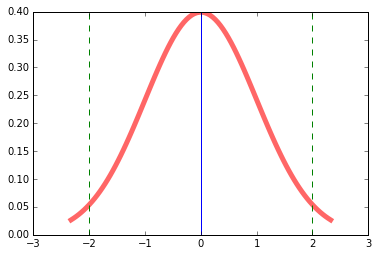

In [13]:
from scipy.stats import norm
mean, var, skew, kurt = norm.stats(moments='mvsk')
x = np.linspace(norm.ppf(0.01),
              norm.ppf(0.99), 100)
fig,ax = plt.subplots()
ax.plot(x, norm.pdf(x),
        'r-', lw=5, alpha=0.6, label='norm pdf')
ax.axvline(mean)
ax.axvline(mean+2*np.sqrt(var), ls='--', c='g')
ax.axvline(mean-2*np.sqrt(var), ls='--', c='g')


p_Gaussian = norm.sf(mean-2*np.sqrt(var))-norm.sf(mean+2*np.sqrt(var))
print(p_Gaussian)

Note: median from numpy_weighted_median  should be the same as 50-th weighted quantile... 
and it isn't ! 

In [14]:
#weighted median taking as x the ordinances, and as y the values of the Gaussian PDF 
varF.calcWeightedPercentile(x, norm.pdf(x))

0.0

In [11]:
print('For sigma and p(sigma):')
print('weighted stats numpy_weighted_median %f'%varF.calcWeightedPercentile(sigma, p_sigma))


For sigma and p(sigma):
weighted stats numpy_weighted_median 1.154744


Looks all good  - finally I'll do a quick benchmark  to see how long does it take to calculate the statistics per PDF (we calculate one PDF per lightcurve, each PDF has exactly 70 points in sigma-space, so this would be exactly the same overhead for each lightcurve). 

In [16]:
%matplotlib inline
# initialize the time series 
sigma_0 = 1.0 
A = 1.0 
N = 100 
Nboot = 10000

# calculate the integral between +/- 2 st.dev. in a true Gaussian 
from scipy.stats import norm
mean, var, skew, kurt = norm.stats(moments='mvsk')
p_Gaussian = norm.sf(mean-2*np.sqrt(var))-norm.sf(mean+2*np.sqrt(var))


t = np.linspace(0,2*np.pi, num=N)
A = 1.0 

ei = np.random.normal(loc=0.0, scale=sigma_0, size=len(t)) 
xi = A* np.sin(t) + 1 + ei
plot_data, mu_max, sigma_max = varF.get_mu_sigma(xi,ei, N_boot=Nboot, return_plot_data=True)

def calc_p_sigma_details(plot_data):

    mu, sigma = plot_data['mu'], plot_data['sigma']
    p_mu, p_sigma = plot_data['p_mu'], plot_data['p_sigma']

    # calculate the mean, median, standard deviation
    E = np.sum(p_sigma*sigma) / np.sum(p_sigma)   # mean 
    stdev = np.sqrt(np.sum(sigma*sigma*p_sigma)/ np.sum(p_sigma)  - E*E)  # stdev 
    median = varF.calcWeightedPercentile(sigma,p_sigma,50)

    # weighted interquartile sigmaG 
    q75 = varF.calcWeightedPercentile(sigma, p_sigma, 75)
    q25 = varF.calcWeightedPercentile(sigma, p_sigma, 25) 
    sigmaG_weighted  = 0.7413 * (q75-q25)

    # prob of being within +/- w stdev 
    dsigma = sigma[1]-sigma[0]
    mask = (sigma < E+2*stdev) * (sigma > E-2*stdev)
    prob = np.sum(p_sigma[mask]*dsigma)
    if prob >= p_Gaussian:
        GaussLike = True
    else:
        GaussLike = False  

    # store data for this PDF 
    stats = {}
    stats['mean'] = E
    stats['median'] = median 
    stats['stdev'] = stdev
    stats['sigmaG'] = sigmaG_weighted
    stats['probInTwoStdev'] = prob
    stats['GaussLike'] = GaussLike



In [17]:
result = %timeit -o calc_p_sigma_details(plot_data)

1000 loops, best of 3: 205 µs per loop


This means that with $5 \cdot 10^{6}$ lightcurves it would take $11$ days to calculate on my mac. But magneto is faster, much faster.  So all that would take much less time 